<h1 style="text-align: center; font-weight: bold;">
Model LSTM for Time Series Forecasting Temperature
</h1>


# LLibreries

In [26]:
# 📦 Gestió bàsica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# 📊 Tractament i visualització de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuració visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# 📈 Barra de progrés
from tqdm.notebook import tqdm

# 🧪 Preprocessament i mètriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# 🤖 TensorFlow i Keras — Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model


# Funcions pròpies

import importlib
import lstm_functions
importlib.reload(lstm_functions)



<module 'lstm_functions' from '/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/lstm_functions.py'>

# Dades


## Importació de dades dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [12]:
#Directori de treball

# Ruta on esta el script actual
__path__ = os.getcwd() # Si es fitxer .ipynb
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py

# Carpeta on es troben les dades
carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'

# Fitxers de dades
fitxer_dades_csv = 'SCM_T_Z1.csv' # Nom del fitxer CSV amb totes les dades
fitxer_dades_csv_2009_2019 = 'SCM_T_Z1_2009_2019.csv' # Nom del fitxer CSV amb les dades de 2009 a 2019
fitxer_dades_csv_2020_2024 = 'SCM_T_Z1_2020_2024.csv' # Nom del fitxer CSV amb les dades de 2020 a 2024 (final dades)

# Path complet al fitxer CSV
path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)
path_dades_2009_2019 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2009_2019)
path_dades_2020_2024 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2020_2024)


# Importar les dades 2020_2024 per LSTM ja que son recents i no tenen interrupcions ni valors nuls

df_lstm = pd.read_csv(path_dades_2020_2024)

# Convertir la columna 'data' a tipus datetime
df_lstm['data'] = pd.to_datetime(df_lstm['data'], utc=True)

# Comprovar si hi ha valors nuls
print("Valors nuls per columna en dades LSTM:")
print(df_lstm.isnull().sum())

# Mostrar el df

df_lstm


Valors nuls per columna en dades LSTM:
data     0
valor    0
dtype: int64


,data,valor
0,2020-01-01 00:00:00+00:00,1.30
1,2020-01-01 01:00:00+00:00,1.60
2,2020-01-01 02:00:00+00:00,3.20
3,2020-01-01 03:00:00+00:00,4.40
4,2020-01-01 04:00:00+00:00,4.00
...,...,...
43843,2024-12-31 19:00:00+00:00,0.10
43844,2024-12-31 20:00:00+00:00,-0.60
43845,2024-12-31 21:00:00+00:00,-0.60
43846,2024-12-31 22:00:00+00:00,-0.70


## Visualització Prèvia de les dades

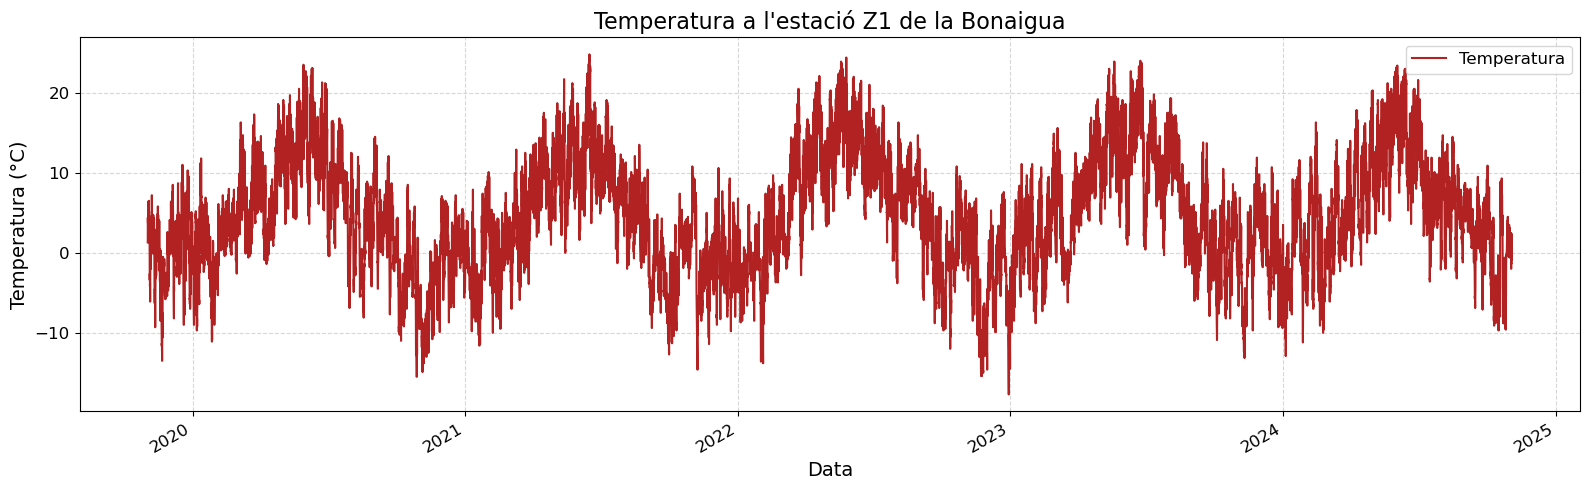

In [13]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Separació de les dades en entrenament, validació i test

In [14]:
# Definim les dates límit per la separació
data_max = df_lstm['data'].max()

data_limit_train = data_max - pd.DateOffset(months=6)      # Límit final del train
data_limit_val = data_max - pd.DateOffset(months=3)        # Límit final de la validació

# Separem els datasets
df_train = df_lstm[df_lstm['data'] <= data_limit_train].copy().reset_index(drop=True)
df_val = df_lstm[(df_lstm['data'] > data_limit_train) & (df_lstm['data'] <= data_limit_val)].copy().reset_index(drop=True)
df_test = df_lstm[df_lstm['data'] > data_limit_val].copy().reset_index(drop=True)


## Visualització dels conjunts de dades

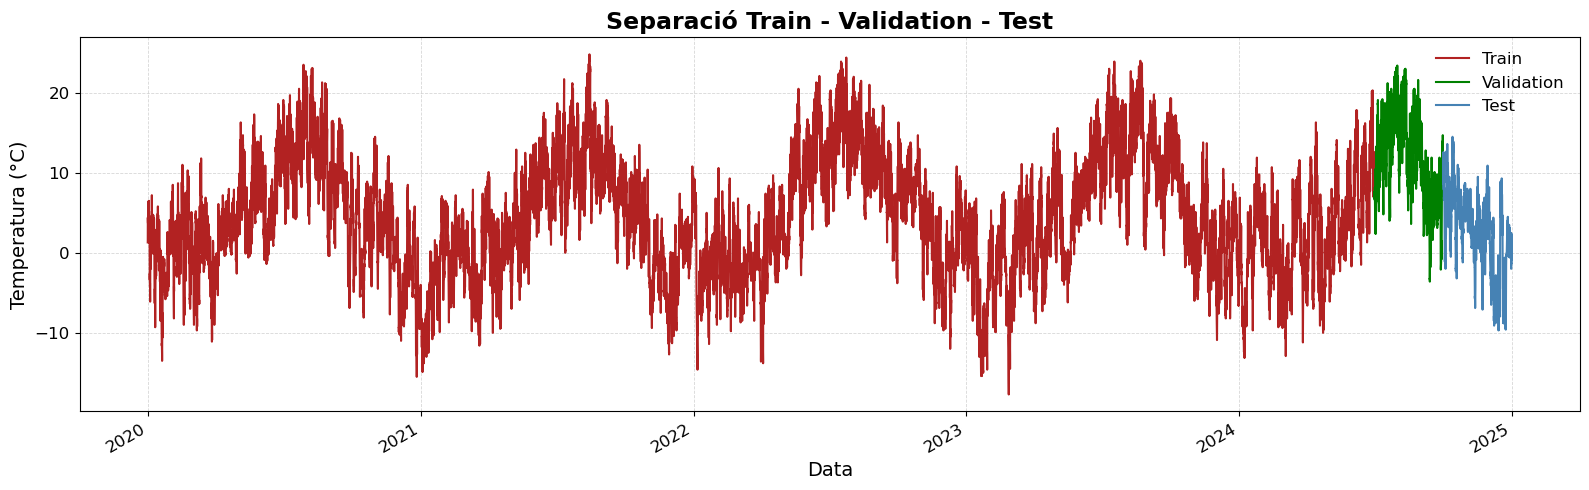

In [15]:
# Confirmem la separació amb un gràfic
plt.figure(figsize=(16, 5))
plt.plot(df_train['data'], df_train['valor'], label='Train', color='firebrick', linewidth=1.5)
plt.plot(df_val['data'], df_val['valor'], label='Validation', color='green', linewidth=1.5)
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

plt.title('Separació Train - Validation - Test', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


# Definicó de Funcions

In [22]:
# Funció per escalar les dades a milers

def escala_mil(x, pos):
    """
    Funció per formatar els ticks de l’eix Y multiplicant per 1000.
    És útil quan vols mostrar valors petits (com MSE en [0, 0.01]) en una escala més llegible.

    Args:
        x (float): valor del tick original (per exemple, 0.0013).
        pos (int): posició del tick en l’eix (0, 1, 2...). No s’utilitza aquí, però és necessari
                   perquè FuncFormatter sempre crida la funció amb dos arguments.

    Returns:
        str: valor formatat com a string, multiplicat per 1000 i amb 1 decimal (ex: '1.3').
    """
    val = x * 1000
    return f'{val:.1f}'



# Creem una funció per crear sequences per LSTM d'entrada

def create_sequences(series, window_size, n_outputs=1, n_slide=1):
    """
    Crea seqüències d'entrada i sortida per predicció simple o multi-output, 
    amb control del pas de desplaçament entre finestres.

    Args:
        series (array): sèrie temporal escalada.
        window_size (int): llargada de la finestra d'entrada.
        n_outputs (int): nombre de passos a predir (per defecte 1).
        n_slide (int): quant avancem la finestra a cada iteració (per defecte 1).

    LSTM espera una entrada en 3 dimensions:
    (n_samples, window_size, n_features)
        On:
    - n_samples = nombre de finestres que hem generat
    - window_size = longitud de cada finestra (número de valors consecutius)
    - n_features = nombre de variables per timestep (en aquest cas, 1 sola: la temperatura)

    Returns:
        X (np.array): seqüències d'entrada, forma (samples, window_size, 1).
        y (np.array): seqüències de sortida, forma (samples, n_outputs) si n_outputs > 1, 
                      o (samples, 1) si n_outputs = 1.
    """
    X, y = [], []
    i = window_size
    while i <= len(series) - n_outputs:
        X.append(series[i - window_size:i])
        if n_outputs == 1:
            y.append(series[i])
        else:
            y.append(series[i:i + n_outputs])
        i += n_slide
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y)
    if n_outputs == 1:
        y = y.reshape(-1, 1)  # Ara fa el reshape que Keras espera per a regressió 1D
        
    return X, y


def escalar_dades(df_train, df_val, df_test, columna='valor', verbose=True):
    """
    Escala els valors d'una columna numèrica utilitzant MinMaxScaler.
    L'ajust es fa només sobre el conjunt de train, i després s'aplica als altres.

    Parameters:
    - df_train, df_val, df_test: DataFrames amb la columna a escalar
    - columna: nom de la columna a escalar (per defecte 'valor')

    Returns:
    - df_train, df_val, df_test: DataFrames amb una nova columna 'columna_scaled'
    - scaler: objecte MinMaxScaler ja entrenat
    """
    
    # Importem el Scaler
    scaler = MinMaxScaler()

    # Escalar només sobre train i transformar val i test
    df_train[f'{columna}_scaled'] = scaler.fit_transform(df_train[[columna]])
    df_val[f'{columna}_scaled'] = scaler.transform(df_val[[columna]])
    df_test[f'{columna}_scaled'] = scaler.transform(df_test[[columna]])


    # Observem com queden les dades
    print('✅ Escalat completat:')
    print("\n")

    if verbose:

        print('Train dataset shape:', df_train.shape)
        display(df_train.head())

        print('Validation dataset shape:', df_val.shape)
        display(df_val.head())

        print('Test dataset shape:', df_test.shape)
        display(df_test.head())

    return df_train, df_val, df_test, scaler


In [ ]:
def prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='pred_batch'):
    """
    Fa una predicció batch (totes les finestres alhora), desescala les prediccions i les afegeix directament a df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d’entrada per a la predicció (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor' desescalada. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions (per defecte 'pred_batch').

    Returns:
        df_test_pred (DataFrame): DataFrame amb la nova columna de predicció.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    # Predicció i desescalat
    y_pred = model.predict(X_test, verbose=0)
    y_pred_rescaled = scaler.inverse_transform(y_pred).flatten()

    # Assignar al DataFrame (ignorant les primeres files sense prou context)
    window_size = X_test.shape[1]
    idx_valid = df_test_pred.index[window_size:]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred




def prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter'):
    """
    Fa una predicció multi-step iterativa, reinjectant cada predicció com a nou input,
    i afegeix les prediccions desescalades directament a df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d’entrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor' desescalada. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions (per defecte 'pred_iter').

    Returns:
        df_test_pred (DataFrame): amb la nova columna de predicció iterativa afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    window_size = X_test.shape[1]
    n_passos = X_test.shape[0]

    seq = X_test[0].copy()  # Seqüència inicial escalada (window_size, 1)
    preds_scaled = []

    for _ in range(n_passos):
        input_seq = seq.reshape((1, window_size, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        preds_scaled.append(pred_scaled)
        seq = np.append(seq[1:], [[pred_scaled]], axis=0)

    # Desescalar les prediccions
    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # Assignar les prediccions desescalades al final del DataFrame
    idx_valid = df_test_pred.index[window_size:window_size + n_passos]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred



def prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject'):
    """
    Fa una predicció iterativa amb reinjecció de valors reals cada 'reinjeccio' passos,
    i afegeix les prediccions desescalades al df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d’entrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor_scaled'. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        reinjeccio (int): nombre de passos entre reinjeccions de dades reals.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions.

    Returns:
        df_test_pred (DataFrame): amb la nova columna de prediccions afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    window_size = X_test.shape[1]
    n_passos = X_test.shape[0]

    valors_scaled = df_test_pred['valor_scaled'].values
    preds_scaled = []

    # Inicialitzem amb valors reals escalats
    # seq = X_test[0].copy()  # Seqüència inicial (forma: (window_size, 1))
    seq = valors_scaled[:window_size].reshape(-1, 1).copy()
    
    for i in range(n_passos):
        input_seq = seq.reshape((1, window_size, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        preds_scaled.append(pred_scaled)

        if (i + 1) % reinjeccio == 0:
            start_real = i + 1
            end_real = start_real + window_size
            if end_real <= len(valors_scaled):
                seq = valors_scaled[start_real:end_real].reshape(-1, 1).copy()
            else:
                seq = np.append(seq[1:], [[pred_scaled]], axis=0)
        else:
            seq = np.append(seq[1:], [[pred_scaled]], axis=0)


    # Desescalar prediccions
    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # Assignar al DataFrame
    n_preds = len(preds_scaled)
    idx_valid = df_test_pred.index[window_size : window_size + n_preds]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred


# Preparació de les dades per a l'entrenament del model (escalació)

In [17]:
# Escalem la data

scaler = MinMaxScaler()

# Escalar només sobre train i transformar val i test
df_train['valor_scaled'] = scaler.fit_transform(df_train[['valor']])
df_val['valor_scaled'] = scaler.transform(df_val[['valor']])
df_test['valor_scaled'] = scaler.transform(df_test[['valor']])


# Observem com queden les dades
print('Train dataset shape:', df_train.shape)
display(df_train.head())

print('Validation dataset shape:', df_val.shape)
display(df_val.head())

print('Test dataset shape:', df_test.shape)
display(df_test.head())

Train dataset shape: (39432, 3)


,data,valor,valor_scaled
0,2020-01-01 00:00:00+00:00,1.30,0.45
1,2020-01-01 01:00:00+00:00,1.60,0.45
2,2020-01-01 02:00:00+00:00,3.20,0.49
3,2020-01-01 03:00:00+00:00,4.40,0.52
4,2020-01-01 04:00:00+00:00,4.00,0.51


Validation dataset shape: (2208, 3)


,data,valor,valor_scaled
0,2024-07-01 00:00:00+00:00,7.60,0.60
1,2024-07-01 01:00:00+00:00,6.80,0.58
2,2024-07-01 02:00:00+00:00,6.90,0.58
3,2024-07-01 03:00:00+00:00,6.90,0.58
4,2024-07-01 04:00:00+00:00,7.10,0.58


Test dataset shape: (2208, 3)


,data,valor,valor_scaled
0,2024-10-01 00:00:00+00:00,8.60,0.62
1,2024-10-01 01:00:00+00:00,9.70,0.64
2,2024-10-01 02:00:00+00:00,10.20,0.66
3,2024-10-01 03:00:00+00:00,10.50,0.66
4,2024-10-01 04:00:00+00:00,10.40,0.66


# 🧠 Model LSTM — 1 output 

## Preparació de les seqüències per a l'entrenament

In [19]:
# Parametres Globals del model LSTM

# Parametrització per a la creació de seqüències 
WINDOW_SIZE = 24  # provar més tard 48, 72, 168...
N_OUTPUTS = 1  # Per predicció simple, si fos multi-step seria > 1
N_SLIDE = 1  # Desplaçament de la finestra, 1 per predicció simple
N_FEATURES = 1  # Només una variable: temperatura

In [21]:
# Creem una copia del df_test per evitar canviar el df original i afegim les dades escalades i les posteriors prediccions
df_test_pred = df_test.copy()

# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)


# Mostrem les dimensions dels conjunts de dades
print("🧾 Dimensions dels conjunts:")
print("")
print(f"  📘 Train → X: {X_train.shape} | y: {y_train.shape}")
print("---------------------------")
print(f"  📙 Validació → X: {X_val.shape} | y: {y_val.shape}")
print("---------------------------")
print(f"  📕 Test → X: {X_test.shape} | y: {y_test.shape}")

🧾 Dimensions dels conjunts:

  📘 Train → X: (39408, 24, 1) | y: (39408, 1)
---------------------------
  📙 Validació → X: (2184, 24, 1) | y: (2184, 1)
---------------------------
  📕 Test → X: (2184, 24, 1) | y: (2184, 1)


## Deficinió del Model


In [18]:
# =================================================
# Creem el directori per guardar/carregar el model 
# =================================================

nom_model = 'lstm_model.h5'
carpeta_model = 'models'
model_path = os.path.join(__path__, carpeta_model, nom_model)
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Assegurem que el directori existeix

In [19]:

# ============================
# Definim el model LSTM
# ============================

model = Sequential([
    # 1a capa LSTM amb 64 neurones (unitats)
    # - return_sequences=True perquè tenim més capes LSTM després
    # - input_shape = (timesteps, features) → cada seqüència té X valors de temperatura (1 feature)
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),

    # Dropout per reduir overfitting (desactiva aleatòriament un 20% de les neurones durant l'entrenament)
    Dropout(0.2),

    # 2a capa LSTM (encara retorna seqüències per passar-les a la següent LSTM)
    LSTM(64, return_sequences=True),
    Dropout(0.2),

    # 3a capa LSTM (última → no retorna seqüència, només la sortida final)
    LSTM(64),
    Dropout(0.2),

    # Capa de sortida Dense:
    # - 1 neurona perquè fem una predicció escalar (una sola temperatura)
    Dense(N_OUTPUTS)
])

# Compilació del model:
# - Optimitzador Adam → ajusta els pesos de forma eficient
# - Funció de pèrdua MSE → ideal per problemes de regressió com el nostre

model.compile(
    optimizer='adam',
    loss='mse'
)


## Entrenament del Model

In [ ]:
# =========================================================
# Entrenament del model multi-output
# =========================================================

# Reproduïbilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [ ]:

# Callback EarlyStopping per aturar l'entrenament si no millora el val_loss
early_stop = EarlyStopping(
    monitor='val_loss',      # monitoritza la pèrdua de validació
    patience=5,              # espera 5 epochs sense millora abans d'aturar
    restore_best_weights=True  # recupera els pesos del millor epoch
)


In [ ]:

# Entrenament del model:
# - epochs = 50 → nombre d'iteracions sobre tot el dataset
# - batch_size = 32 → nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False → mantenim l'ordre de les dades per més control

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32, # mida del lot per l'entrenament
    validation_data=(X_val, y_val),  # validació amb dades de validació separades
    callbacks=[early_stop],
    verbose=1,
    shuffle=False  # opcional, si vols control total de l'ordre
)

In [ ]:
print(model.summary())

In [ ]:
# ============================================
# Gràfic de la pèrdua durant l'entrenament
# ============================================

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(history.history['loss'], label='Pèrdua Entrenament')
ax.plot(history.history['val_loss'], label='Pèrdua Validació')
ax.set_title("Evolució de la pèrdua durant l'entrenament")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (×10⁻³)")

# Per ticks x cada 2 epochs
ax.set_xticks(np.arange(0, len(history.history['loss']), 1))

# Format ticks y amb 1 decimal
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))

# Força ticks a enters (però com fem decimals, pot ser opcional)
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))  # nbins controla nombre màxim ticks

ax.legend()
ax.grid(True)
plt.show()


In [ ]:
# =======================================
# Guardem i carreguem el model entrenat
# =======================================

# Guarda només l'arquitectura i els pesos, sense optimitzador ni funció de pèrdua
model.save(model_path, include_optimizer=False)

## Carregar Model (Si ja tenim un entrenat)

In [20]:
# Carrega del model guardat
model = load_model(model_path)
print("Model carregat correctament des de:", model_path)
print(model.summary())

Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/models/lstm_model.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model 

### Predicció batch

In [30]:
df_test_pred = prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='prediccio_batch')

In [31]:
# Avaluació de les mètriques

rmse_batch = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:]))
mse_batch = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:])
mae_batch = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció batch: ")
print(f"   ▸ RMSE: {rmse_batch:.4f} °C")
print(f"   ▸ MSE: {mse_batch:.4f} °C²")
print(f"   ▸ MAE: {mae_batch:.4f} °C")

📊 Mètriques predicció batch: 
   ▸ RMSE: 0.8742 °C
   ▸ MSE: 0.7642 °C²
   ▸ MAE: 0.6152 °C


### Predicció Multi-Step Iterativa

In [32]:
df_test_pred = prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='prediccio_iter')

In [33]:
# Avaluació de les mètriques

rmse_iter = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:]))
mse_iter = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:])
mae_iter = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció iterativa: ")
print(f"   ▸ RMSE: {rmse_iter:.4f} °C")
print(f"   ▸ MSE: {mse_iter:.4f} °C²")
print(f"   ▸ MAE: {mae_iter:.4f} °C")

📊 Mètriques predicció iterativa: 
   ▸ RMSE: 10.9260 °C
   ▸ MSE: 119.3783 °C²
   ▸ MAE: 9.7996 °C


### Predicció iterativa amb reinjecció de dades

In [34]:
df_test_pred

,data,valor,valor_scaled,prediccio_reinject,prediccio_batch,prediccio_iter
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN,NaN,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN,NaN,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN,NaN,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN,NaN,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN,NaN,NaN
...,...,...,...,...,...,...
2203,2024-12-31 19:00:00+00:00,0.10,0.42,3.48,-0.93,11.82
2204,2024-12-31 20:00:00+00:00,-0.60,0.40,-0.21,-0.21,11.82
2205,2024-12-31 21:00:00+00:00,-0.60,0.40,-0.09,-0.39,11.82
2206,2024-12-31 22:00:00+00:00,-0.70,0.40,-0.10,-0.64,11.82


In [ ]:
df_test_pred = prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='prediccio_reinject')

In [26]:
df_test_pred

,data,valor,valor_scaled,prediccio_reinject
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN
...,...,...,...,...
2203,2024-12-31 19:00:00+00:00,0.10,0.42,3.48
2204,2024-12-31 20:00:00+00:00,-0.60,0.40,-0.21
2205,2024-12-31 21:00:00+00:00,-0.60,0.40,-0.09
2206,2024-12-31 22:00:00+00:00,-0.70,0.40,-0.10


In [27]:
# Avaluació de les mètriques

rmse_reinj = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:]))
mse_reinj = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:])
mae_reinj = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció amb reinjecció: ")
print(f"   ▸ RMSE: {rmse_reinj:.4f} °C")
print(f"   ▸ MSE: {mse_reinj:.4f} °C²")
print(f"   ▸ MAE: {mae_reinj:.4f} °C")

📊 Mètriques predicció amb reinjecció: 
   ▸ RMSE: 1.8570 °C
   ▸ MSE: 3.4486 °C²
   ▸ MAE: 1.3098 °C


## Mètriques, errors i graficació 

In [36]:
# Taula comparativa de mètriques
mètriques = pd.DataFrame({
    'Mètrica': ['RMSE', 'MSE', 'MAE'],
    'Predicció Batch': [rmse_batch, mse_batch, mae_batch],
    'Predicció Iterativa': [rmse_iter, mse_iter, mae_iter],
    'Predicció Reinjecció': [rmse_reinj, mse_reinj, mae_reinj]
})
mètriques.set_index('Mètrica', inplace=True)
mètriques = mètriques.round(4)  # Arrodonim a 4 decimals
mètriques

,Predicció Batch,Predicció Iterativa,Predicció Reinjecció
Mètrica,,,
RMSE,0.87,10.93,1.86
MSE,0.76,119.38,3.45
MAE,0.62,9.80,1.31


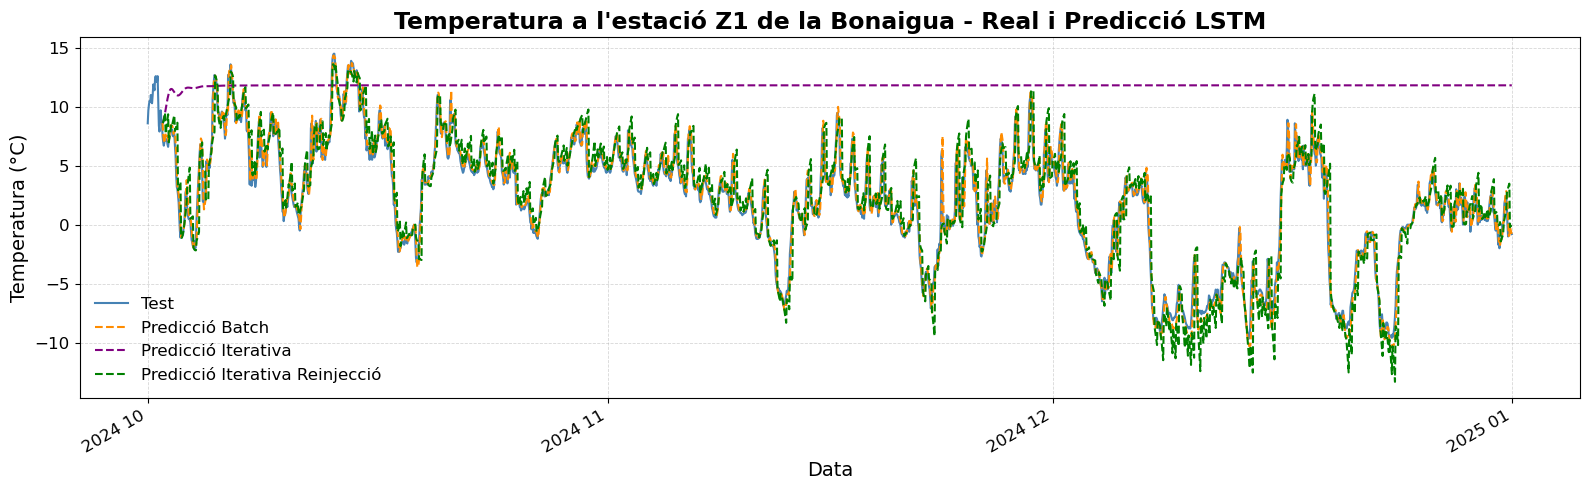

In [69]:
# Ploteig de les dades i les prediccions
plt.figure(figsize=(16, 5))  


# Defineix si es vol mostrar validació i train últims X dies
# Últims dies del train i validació

validation = False  # Si vols mostrar també la validació

dies_enrere = 0 # Dies enrere que vols mostrar del train (0 per no mostrar, >0 per mostrar els últims dies)
dies_enrere = max(dies_enrere, 0)  # Assegura que sigui >= 0

if validation == True:
    if dies_enrere > 0:

        # Ploteja últims dies de Train
        data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
        df_train_filtrat = df_train[df_train['data'] >= data_limit]

        plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label=f'Train (últims {dies_enrere} dies)', color='firebrick', linewidth=1.5)

    # Ploteja Validation (en tots els casos on validation=True)
    plt.plot(df_val['data'], df_val['valor'],label='Validation', color='darkgreen', linewidth=1.5)


# Plot Test complet
plt.plot(df_test_pred['data'], df_test_pred['valor'], label='Test', color='steelblue', linewidth=1.5)

# Plot Predicció Bacth
plt.plot(df_test_pred['data'], df_test_pred['prediccio_batch'], label='Predicció Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa
plt.plot(df_test_pred['data'], df_test_pred['prediccio_iter'], label='Predicció Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa amb reinjecció
plt.plot(df_test_pred['data'], df_test_pred['prediccio_reinject'], label='Predicció Iterativa Reinjecció', color='green', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estació Z1 de la Bonaigua - Real i Predicció LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [61]:
# Calcular els errors de les diferents prediccions
df_test_pred['error_batch'] = df_test_pred['valor'] - df_test_pred['prediccio_batch']
df_test_pred['error_iter'] = df_test_pred['valor'] - df_test_pred['prediccio_iter']
df_test_pred['error_reinject'] = df_test_pred['valor'] - df_test_pred['prediccio_reinject']

df_test_pred.head() 


,data,valor,valor_scaled,prediccio_reinject,prediccio_batch,prediccio_iter,error_batch,error_iter,error_reinject
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN,NaN,NaN,NaN,NaN,NaN


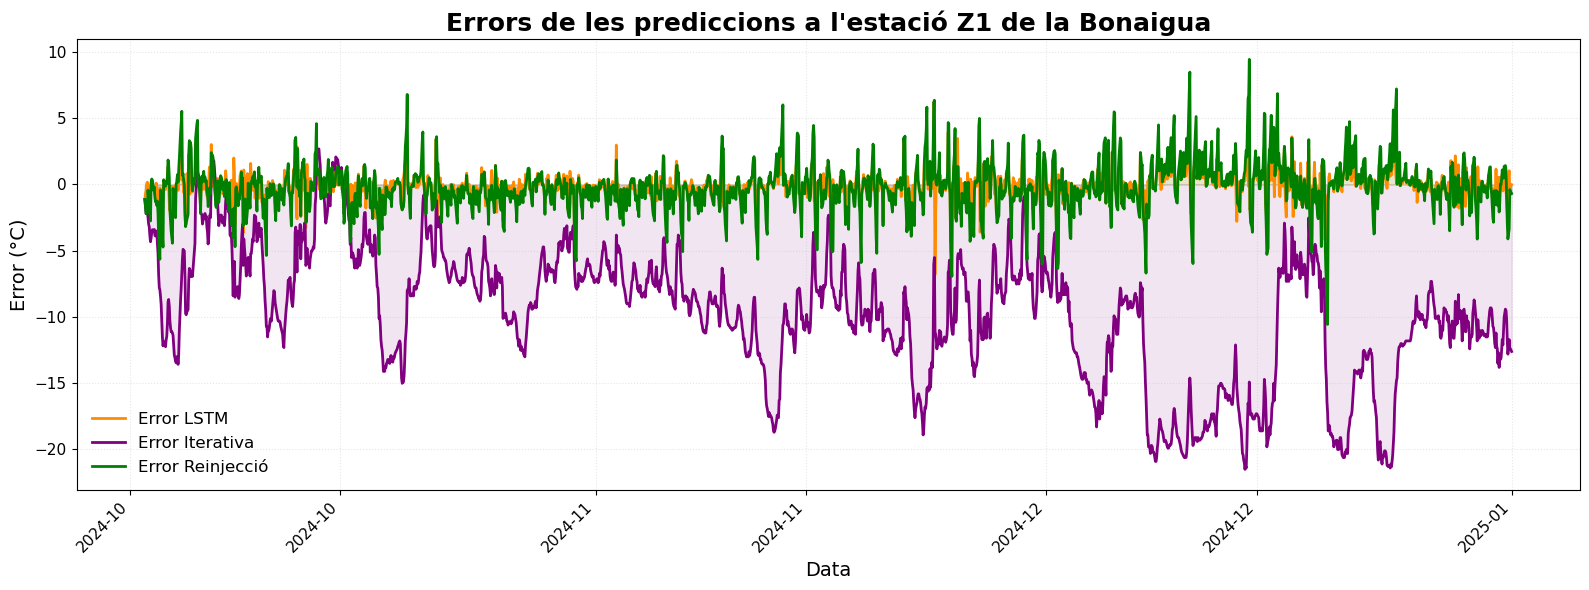

In [63]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ens assegurem que 'data' és de tipus datetime
df_test_pred['data'] = pd.to_datetime(df_test_pred['data'])

plt.figure(figsize=(16, 6))

# Plot de cada línia amb àrea sota
for col, color, label in zip(
    ['error_batch', 'error_iter', 'error_reinject'],
    ['darkorange', 'purple', 'green'],
    ['Error LSTM', 'Error Iterativa', 'Error Reinjecció']
):
    x = df_test_pred['data']
    y = df_test_pred[col].astype(float)
    plt.plot(x, y, label=label, color=color, linewidth=2)
    plt.fill_between(x, 0, y, color=color, alpha=0.1)

# Estètica del gràfic
plt.title("Errors de les prediccions a l'estació Z1 de la Bonaigua", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Error (°C)", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(fontsize=12, frameon=False)

# Format de dates automàtic segons l'interval real del DataFrame
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


# 📈 Model Multioutput LSTM


## Preparació de les seqüències per a l'entrenament

In [76]:
# Parametres Globals del model LSTM

# Parametrització per a la creació de seqüències multi-step 
WINDOW_SIZE = 24  # provar més tard 48, 72, 168...
N_OUTPUTS = 5  # Nombre de passos de predicció futura (multi-step)
N_SLIDE = N_OUTPUTS  # Desplaçament de la finestra, 1 per predicció simple
N_FEATURES = 1  # Només una variable: temperatura


In [77]:
# Creem una copia de df_test per aquest model multi-step
df_test_pred_multi = df_test.copy()


# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred_multi['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)

In [78]:
print("🧾 Dimensions dels conjunts:")
print("")
print(f"  📘 Train → X: {X_train.shape} | y: {y_train.shape}")
print("---------------------------")
print(f"  📙 Validació → X: {X_val.shape} | y: {y_val.shape}")
print("---------------------------")
print(f"  📕 Test → X: {X_test.shape} | y: {y_test.shape}")


🧾 Dimensions dels conjunts:

  📘 Train → X: (7881, 24, 1) | y: (7881, 5)
---------------------------
  📙 Validació → X: (436, 24, 1) | y: (436, 5)
---------------------------
  📕 Test → X: (436, 24, 1) | y: (436, 5)


## Definició del Model Multioutput

In [79]:
# ========================================================================
# Creem el directori per guardar/carregar el model multi-output
# ========================================================================

nom_model_multi = 'lstm_model_multioutput.h5'
carpeta_model_multi = 'models'
model_multi_path = os.path.join(__path__, carpeta_model_multi, nom_model_multi)
os.makedirs(os.path.dirname(model_multi_path), exist_ok=True)

In [80]:
# ==================================================
# Definim el model LSTM multi-output
# ==================================================

model_multi = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(N_OUTPUTS)  # Capa final amb tantes neurones com outputs vulguem
])

model_multi.compile(
    optimizer='adam',
    loss='mse'
)

## Entrenament del Model Multioutput

In [ ]:
# =========================================================
# Entrenament del model multi-output
# =========================================================

# Reproductibilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [ ]:

# Callback per early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:

# Entrenament del model:
# - epochs = 50 → nombre d'iteracions sobre tot el dataset
# - batch_size = 32 → nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False → mantenim l'ordre de les dades per més control

history_multi = model_multi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

In [ ]:
print(model_multi.summary())

In [ ]:
# ============================================
# Gràfic de la pèrdua durant l'entrenament
# ============================================

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history_multi.history['loss'], label='Pèrdua Entrenament')
ax.plot(history_multi.history['val_loss'], label='Pèrdua Validació')
ax.set_title("Evolució de la pèrdua durant l'entrenament (multi-output)")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (×10⁻³)")
ax.set_xticks(np.arange(0, len(history_multi.history['loss']), 5))
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))
ax.legend()
ax.grid(True)
plt.show()


In [ ]:
# =======================================
# Guardem i carreguem el model entrenat
# =======================================

# Guarda només l'arquitectura i els pesos, sense optimitzador ni funció de pèrdua
model_multi.save(model_multi_path, include_optimizer=False)

## Carregar Model Multi (Si ja tenim un entrenat)

In [81]:
# Carreguem el model
model_multi = load_model(model_multi_path)
print("Model carregat correctament des de:", model_multi_path)
print(model_multi.summary())


Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/models/lstm_model_multioutput.h5


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,269 (325.27 KB)

 Trainable params: 83,269 (325.27 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model Multioutput

### Predicció batch multioutput

In [84]:
# Funció per fer prediccions multi-step

def prediccio_batch_multi(model, X_test, df_test, scaler, window_size, n_outputs, nom_columna='pred_batch_multi'):

    """
    Fa prediccions multi-output de manera contínua i enganxa totes les prediccions al DataFrame original.

    Supòsits:
    - S'utilitzen seqüències creades amb `n_slide = n_outputs`, per tant NO hi ha solapament entre finestres.
    - Cada finestra prediu exactament els següents `n_outputs` valors, i la següent finestra continua on acaba l’anterior.

    Args:
        model: Model LSTM multi-output entrenat.
        X_test (np.array): Matriu d’entrada per a test (n_samples, window_size, 1).
        df_test (pd.DataFrame): DataFrame original amb les dades reals, conté almenys la columna 'valor'.
        scaler: MinMaxScaler utilitzat per escalar i desescalar les dades.
        window_size (int): Mida de la finestra d’entrada per a cada seqüència.
        n_outputs (int): Nombre de passos que prediu el model (outputs per finestra).
        nom_columna (str): Nom de la columna on es guardaran les prediccions desescalades.

    Retorna:
        df_test amb la nova columna `nom_columna` que conté les prediccions (amb NaNs on no es pot predir).
    """
    # 1. Fer la predicció batch
    y_pred = model.predict(X_test, verbose=0)

    # 2. Desescalar les prediccions (per tornar a °C)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # 3. Inicialitzem la nova columna amb NaNs
    df_test[nom_columna] = np.nan

    # 4. Omplim la columna amb les prediccions multi-output (una fila per cada pas predit)
    for i in range(len(y_pred_rescaled)):
        for j in range(n_outputs):
            idx = window_size + i * n_outputs + j  # índex corresponent a la predicció j de la i-èsima seqüència
            if idx < len(df_test):
                df_test.at[idx, nom_columna] = y_pred_rescaled[i, j]

    return df_test



In [85]:
# Prova --> Resetejar el df_test_multi
df_test_pred_multi = df_test.copy()

df_test_pred_multi = prediccio_batch_multi(model_multi, X_test, df_test_pred_multi, scaler=scaler, window_size=WINDOW_SIZE, n_outputs=N_OUTPUTS, nom_columna='pred_batch_multi')

df_test_pred_multi

,data,valor,valor_scaled,pred_batch_multi
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN
...,...,...,...,...
2203,2024-12-31 19:00:00+00:00,0.10,0.42,2.55
2204,2024-12-31 20:00:00+00:00,-0.60,0.40,NaN
2205,2024-12-31 21:00:00+00:00,-0.60,0.40,NaN
2206,2024-12-31 22:00:00+00:00,-0.70,0.40,NaN


In [86]:
# Metriques de la predicció multi-output
rmse_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"📊 Mètriques predicció multi-output: ")
print(f"   ▸ RMSE: {rmse_multi:.4f} °C")
print(f"   ▸ MSE: {mse_multi:.4f} °C²")
print(f"   ▸ MAE: {mae_multi:.4f} °C")

📊 Mètriques predicció multi-output: 
   ▸ RMSE: 1.6835 °C
   ▸ MSE: 2.8342 °C²
   ▸ MAE: 1.2866 °C


### Predicció multi-step iterativa multioutput

In [87]:
def prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter'):
    """
    Fa una predicció multi-step iterativa (multi-output), reinjectant les prediccions com a nova entrada,
    i afegeix les prediccions desescalades directament a df_test_pred.

    Assumim que el model prediu diversos passos (multi-output), i que X_test conté una sola seqüència inicial.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d’entrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor' desescalada. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions (per defecte 'pred_iter').

    Returns:
        df_test_pred (DataFrame): amb la nova columna de predicció iterativa afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_preds_total,)).
    """
    window_size = X_test.shape[1]
    n_outputs = model.output_shape[-1]

    seq = X_test[0].copy()  # Seqüència inicial escalada (window_size, 1)
    preds_scaled = []

    n_preds_total = len(df_test_pred) - window_size
    n_steps = n_preds_total // n_outputs

    for _ in range(n_steps):
        input_seq = seq.reshape((1, window_size, 1))  # Afegim dimensió batch
        pred_scaled = model.predict(input_seq, verbose=0)[0]  # (n_outputs,)
        preds_scaled.extend(pred_scaled)

        # Afegim les prediccions escalades al final de la seqüència
        pred_scaled_reshaped = pred_scaled.reshape(-1, 1)
        seq = np.concatenate([seq[n_outputs:], pred_scaled_reshaped], axis=0)

    # Desescalar totes les prediccions
    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # Assignar les prediccions al DataFrame
    idx_valid = df_test_pred.index[window_size:window_size + len(y_pred_rescaled)]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred


In [88]:
df_test_pred_multi = prediccio_multi_step_iterativa(model_multi, X_test, df_test_pred_multi, scaler, nom_columna='pred_iter')

In [89]:
# Metriques de la predicció multi-output
rmse_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"📊 Mètriques predicció multi-output iterativa: ")
print(f"   ▸ RMSE: {rmse_multi:.4f} °C")
print(f"   ▸ MSE: {mse_multi:.4f} °C²")
print(f"   ▸ MAE: {mae_multi:.4f} °C")

📊 Mètriques predicció multi-output iterativa: 
   ▸ RMSE: 9.3801 °C
   ▸ MSE: 87.9855 °C²
   ▸ MAE: 8.1279 °C


### Predicció amb reinjecció de dades real multioutput

In [90]:
def prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject'):
    """
    Fa una predicció iterativa multi-output amb reinjecció de valors reals cada 'reinjeccio' passos.
    Afegeix les prediccions desescalades al df_test_pred.

    Args:
        model: model LSTM multi-output entrenat.
        X_test (np.array): finestres d’entrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor_scaled'. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        reinjeccio (int): cada quants passos es reinjecta el valor real.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions.

    Returns:
        df_test_pred (DataFrame): amb la nova columna de prediccions afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_preds_total,)).
    """
    window_size = X_test.shape[1]
    n_outputs = model.output_shape[-1]
    valors_scaled = df_test_pred['valor_scaled'].values
    preds_scaled = []

    # Inicialitzem amb la primera finestra real
    seq = valors_scaled[:window_size].reshape(-1, 1).copy()

    # Nombre total de passos de predicció (amb salt de n_outputs)
    n_preds_total = len(df_test_pred) - window_size
    n_steps = n_preds_total // n_outputs

    for i in range(n_steps):
        input_seq = seq.reshape((1, window_size, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0]  # (n_outputs,)
        preds_scaled.extend(pred_scaled)

        # Reinjecció cada 'reinjeccio' passos
        if (i + 1) % reinjeccio == 0:
            start_real = i * n_outputs
            end_real = start_real + window_size
            if end_real <= len(valors_scaled):
                seq = valors_scaled[start_real:end_real].reshape(-1, 1).copy()
            else:
                pred_reshaped = pred_scaled.reshape(-1, 1)
                seq = np.concatenate([seq[n_outputs:], pred_reshaped], axis=0)
        else:
            pred_reshaped = pred_scaled.reshape(-1, 1)
            seq = np.concatenate([seq[n_outputs:], pred_reshaped], axis=0)

    # Desescalar i inserir al DataFrame
    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    idx_valid = df_test_pred.index[window_size : window_size + len(y_pred_rescaled)]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred


In [91]:
df_test_pred_multi = prediccio_iterativa_reinjection(model_multi, X_test, df_test_pred_multi, scaler, reinjeccio=5, nom_columna='pred_reinject')

In [94]:
# Metriques de la predicció multi-output
rmse_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"📊 Mètriques predicció multi-output reinject:")
print(f"   ▸ RMSE: {rmse_multi:.4f} °C")
print(f"   ▸ MSE: {mse_multi:.4f} °C²")
print(f"   ▸ MAE: {mae_multi:.4f} °C")

📊 Mètriques predicció multi-output reinject:
   ▸ RMSE: 3.9682 °C
   ▸ MSE: 15.7470 °C²
   ▸ MAE: 3.0281 °C


## Metriques, errors i graficació multioutput

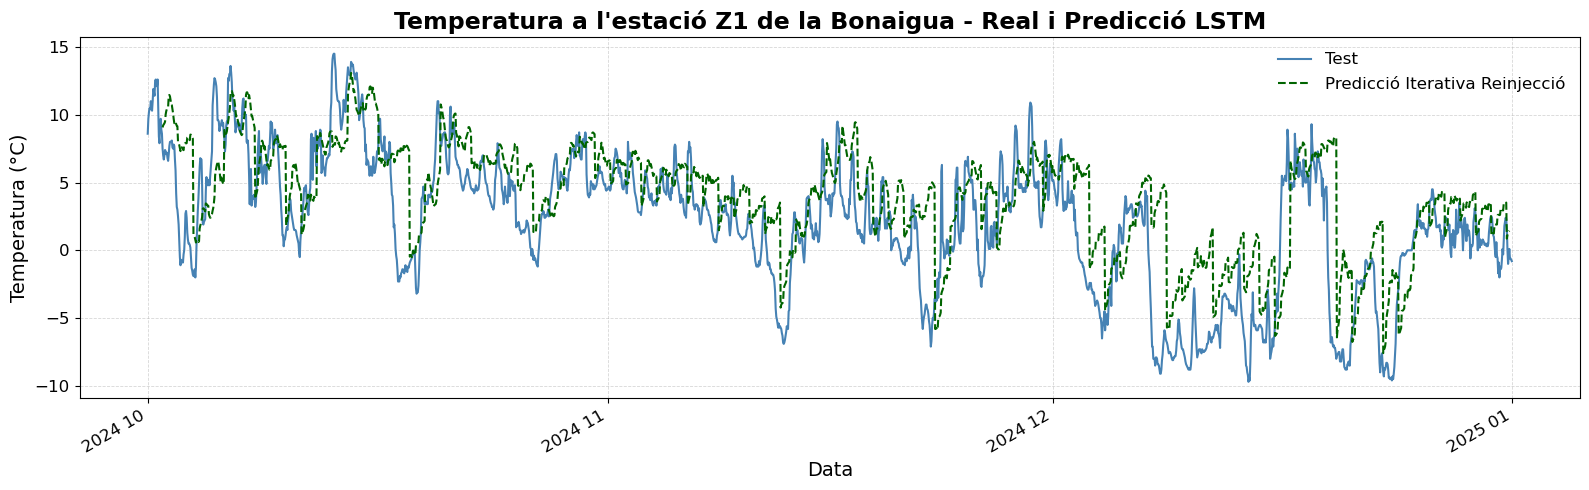

In [95]:
# Ploteig de les dades i les prediccions
plt.figure(figsize=(16, 5))  


# Defineix si es vol mostrar validació i train últims X dies
# Últims dies del train i validació

validation = False  # Si vols mostrar també la validació

dies_enrere = 0 # Dies enrere que vols mostrar del train (0 per no mostrar, >0 per mostrar els últims dies)
dies_enrere = max(dies_enrere, 0)  # Assegura que sigui >= 0

if validation == True:
    if dies_enrere > 0:

        # Ploteja últims dies de Train
        data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
        df_train_filtrat = df_train[df_train['data'] >= data_limit]

        plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label=f'Train (últims {dies_enrere} dies)', color='firebrick', linewidth=1.5)

    # Ploteja Validation (en tots els casos on validation=True)
    plt.plot(df_val['data'], df_val['valor'],label='Validation', color='darkgreen', linewidth=1.5)


# Plot Test complet
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['valor'], label='Test', color='steelblue', linewidth=1.5)

# Plot Predicció Bacth
# plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_batch_multi'], label='Predicció Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa
# plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_iter'], label='Predicció Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa amb reinjecció
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_reinject'], label='Predicció Iterativa Reinjecció', color='darkgreen', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estació Z1 de la Bonaigua - Real i Predicció LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()
